In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
import random
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

## Basic tasks in training a supervised ML model
1. Set up your experimental design (e.g., create train and test set(s) with hold-out, k-fold cross validation, bootstrapping,...) 
2. Preprocess your train set and apply the same preprocessing parameters on your test set
3. Choose an appropriate ML algorithm and instantiate it with some hyperparameters
4. Fit the ML instance with the train set
5. Perform prediction on the test set
6. Evaluate the predicted results with the ground truths with appropriate metric(s) corresponding to the chosen experiment design
7. Repeat step 3 to 6 with different sets of hyperparameters to tune them (optional)

- Know how to use confusion matrix and accuracy as evaluation metrics for multi-class problems
- Know how to select the best attribute used to split the desision tree using information gain criteria
- Understand how descision trees work and are visualised
- Know how to predict numerical data attribute using linear regression model
- Interpret the coefficients of a linear regression model
- Plot and interpret residual plots
- Know how to write a basic ML training pipeline using `scikit-learn` library in Python
- Understand how holdout (train-test split) is implemented in `scikit-learn`

# k-Nearest Neighbours (k-NN)
The $k$-NN algorithm works under the assumption that _similar things exist in close proximity_. That is, similar things are near to each other (not to be confused with $k$-means).

Generally, the $k$-NN algorithm has the following pseudocode

```python
k = chosen number of neighbours
for each example in the data:
    calculate the distance between the query example and the current example from the data.
    add the distance and the index of the example to an ordered collection
    
sort the ordered collection of distances and indices from smallest to largest in ascending order
pick the first k entries from the sorted collection
get the labels of the selected K entries

return the labels of the selected entries
```

**Notes:** $k$-means and $k$-NN are used for different problems:
- $k$-means clustering is unsupervised that looks to gather and group data into $k$ number of clusters by looking at the data points only;
- whilst $k$-NN is a supervised classifier that will classify new data points according to the $k$ nearest data points (that were given in the train dataset).

In [2]:
train = pd.read_csv('supervised_train.csv')
test = pd.read_csv('supervised_test.csv')

In [3]:
X_COLS = ['unit_price', 'time_on_site', 'movie_rating']
y_COL = 'label'

In [4]:
# create design matrix X and predictions y
# split into train and test 
X_train = train[X_COLS]
y_train = train[y_COL]
X_test = test[X_COLS]
y_test = test[y_COL]

In [5]:
# sample 10 random rows as an example
train.sample(10)

,unit_price,time_on_site,quantity,total,label,movie_rating
4533,25,112.152524,5,146.44,Low,6.458847
6007,25,156.973549,1,42.49,Low,8.506081
7834,25,132.341410,4,114.52,Low,7.197770
5880,25,169.721628,9,253.24,High,4.921290
3997,25,146.967526,7,180.38,Medium,6.316480
334,25,143.385226,6,160.55,Medium,6.441223
3710,20,164.027652,7,153.03,Medium,5.462569
4969,20,106.067699,2,62.60,Low,7.432865
7467,25,96.515356,4,120.70,Low,6.883019
3195,25,159.244036,3,100.22,Low,7.717984


In [6]:
# Create and fit knn with k=3
knn = KNeighborsClassifier(n_neighbors=3)

# Fit to the train dataset
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

### Evaluation Metrics
For classifiers like $k$-NN, we normally calculate accuracy, precision, and recall. Note that there are sub-types of these metrics, depending on how many classes we have in the target variable (binary classification vs multi-label/multi-class classification). 

The first step to calculate accuracy, precision, and recall, is to construct the Confusion Matrix.

### Confusion Matrix
The Confusion Matrix is a performance metric for classification problems. It is a table that shows the number of predicted classes vs actual classes. 

If your classification model is good, then you would expect the diagonals to be higher in number.

In [7]:
# Note that we're calculating the accuracy score for the test data
y_pred = knn.predict(X_test)

accuracy = knn.score(X_test, y_test)
print('Accuracy', accuracy)

Accuracy 0.8215


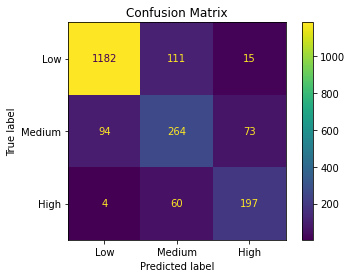

In [8]:
# cm = confusion matrix (variable name)
cm = confusion_matrix(y_test, # test data
                      y_pred, # predictions
                      labels=['Low', 'Medium', 'High'] # class labels from the knn model
                     )

disp = ConfusionMatrixDisplay(confusion_matrix=cm, # pass through the created confusion matrix
                              display_labels=['Low', 'Medium', 'High'] # class labels from the knn model 
                             )

disp.plot()

plt.title("Confusion Matrix")
plt.show()

# Decision Tree Classifiers (DT)
A Decision Tree model works by splitting nodes into sub-nodes based on attributes to classify a data point. This process is performed multiple times during the training process and terminates when only homogenous nodes are left. Therefore, node splitting is a key concept to be aware of.

Node splitting is the process of dividing a node into multiple sub-nodes to create relatively pure nodes. Although trees usually use Gini as a split criterion, we will use the more familiar Entropy method for this example.

## Information Gain (IG)
Information Gain is very similar to Mutual Information (MI) aside from a few small differences. The key difference is that MI works between _two attributes_ whereas IG is used between _one attribute against a class label_.

Recall the MI formula (which was covered in the Correlation workshop and is examinable):

$$
\text{MI}(X, Y) = H(X) – H(X | Y) = H(Y) - H(Y | X)
$$

IG on the other hand is the exact same, but we use `y` to specify that wew are using a class label:  

$$
\text{IG}(X, y) = H(X) – H(X | y) = H(y) - H(y | X)
$$

Like MI, the higher the value, the greater the entropy gained. For IG, we want _more_ information to be gained, hence, it is called _Information Gain_ (go figure).

In [9]:
data = pd.read_csv('dtc.csv')
data

,time_on_site,movie_rating,label
0,Long,Above Average,low
1,Long,Below Average,low
2,Long,Below Average,low
3,Long,Above Average,medium
4,Long,Below Average,low
5,Short,Above Average,medium
6,Short,Above Average,medium
7,Short,Above Average,medium
8,Long,Below Average,medium
9,Long,Above Average,medium


Define our entropy functions (similar to the functions from the Correlation workshop).

In [10]:
def compute_probability(col):
    """
    Compute the probability of a certain event
    """
    return col.value_counts() / col.shape[0]

def compute_entropy(col):
    """
    Compute the entropy of a certain event
    """
    probabilities = compute_probability(col)
    entropy = -sum(probabilities * np.log2(probabilities))
    return entropy

def compute_conditional_entropy(x, y):
    """
    Compute the conditional entropy between two random variables.
    Specifically, the conditional entropy of Y given X.
    """
    probability_x = compute_probability(x)
    
    temp_df = pd.DataFrame({'X': x, 'Y': y})
    
    conditional_entropy = 0
    
    # for unique event x_i
    for x_i in x.unique():
        # get the data for Y given X=x_i
        y_given_x = temp_df.loc[temp_df['X'] == x_i, 'Y']
        
        # compute the conditional entropy
        conditional_entropy += probability_x[x_i] * compute_entropy(y_given_x)
    
    return conditional_entropy

def compute_information_gain(x, y):
    """
    Compute the information gain between an attribute and class label
    """
    return compute_entropy(y) - compute_conditional_entropy(x, y)

In [11]:
for feature in ('time_on_site', 'movie_rating'):
    print(feature, compute_information_gain(data[feature], data['label']).round(4))

time_on_site 0.2813
movie_rating 0.2564


In [12]:
X = OrdinalEncoder().fit_transform(data[['time_on_site', 'movie_rating']])
# data['label'].to_numpy().reshape(-1,1) also works
y = OrdinalEncoder().fit_transform(data[['label']])
print(X)
print(y)

[[0. 0.]
 [0. 1.]
 [0. 1.]
 [0. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 0.]]
[[0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


In [13]:
dt = DecisionTreeClassifier(criterion='entropy' # we specify entropy for IG
                           )
dt.fit(X, y)

DecisionTreeClassifier(criterion='entropy')

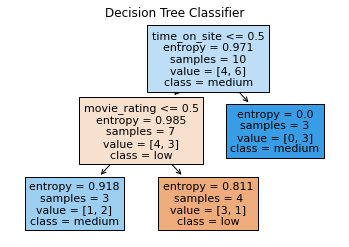

In [14]:
plot_tree(dt, # the DT classifier
          feature_names=['time_on_site', 'movie_rating'], # feature names
          class_names=['low', 'medium'], # class labels
          filled=True # fill in the rectangles
         )

plt.title("Decision Tree Classifier")

plt.show()

In [15]:
FEATURE_COLS = ['unit_price', 'time_on_site', 'movie_rating']
LABEL = 'label'

X_train = train[FEATURE_COLS]
y_train = train[LABEL]
X_test = test[FEATURE_COLS]
y_test = test[LABEL]

dt2 = DecisionTreeClassifier(criterion='entropy')
dt2.fit(X_train, y_train)
y_pred = dt2.predict(X_test)

accuracy = dt2.score(X_test, y_test)
print('Accuracy', accuracy)

Accuracy 0.86


# Linear Regression

Linear regression is a linear model - that is, a model that assumes a **linear relationship** between the input variables (`X`) and the single continuous output variable (`y`). More specifically, that `y` can be calculated from a linear combination of the input variables (`X`). For example, a simple regression with features $x_1$, $x_2$, $x_3$, ... will have the form:  

$$
y = \beta_0 + \beta_1x_1 + \beta_2x_2 + \beta_3x_3 + ...
$$

In [16]:
train = pd.read_csv('supervised_train.csv')
test = pd.read_csv('supervised_test.csv')

# sample 10 random rows as an example
train.sample(10)

,unit_price,time_on_site,quantity,total,label,movie_rating
2711,25,160.148754,7,189.42,Medium,5.518808
5681,25,190.976855,6,156.70,Medium,5.834583
2369,20,141.942241,7,153.24,Medium,5.370265
2884,25,76.771608,5,133.57,Low,6.282787
4102,25,138.600301,7,184.62,Medium,6.040437
1472,25,135.353845,8,213.61,High,5.003762
1114,25,122.567725,5,133.02,Low,5.972297
4621,20,129.277951,2,59.31,Low,6.660301
249,25,120.267449,2,84.33,Low,8.198751
4325,20,111.196141,1,21.62,Low,7.847194


In [17]:
X_COLS = ['unit_price', 'time_on_site', 'movie_rating']
y_COL = 'total'

# create design matrix X and predictions y
# split into train and test 
X_train = train[X_COLS]
y_train = train[y_COL]
X_test = test[X_COLS]
y_test = test[y_COL]

In [18]:
X_train.head()

,unit_price,time_on_site,movie_rating
0,25,171.953089,5.103739
1,20,90.331031,6.357484
2,25,150.916902,8.122554
3,20,84.796902,6.485388
4,25,108.083701,7.884009


In [19]:
y_train.head()

0    198.26
1    120.28
2     51.72
3    112.85
4     51.17
Name: total, dtype: float64

In [20]:
# Create and fit the linear model
# lm = Linear Model (variable name)
lm = LinearRegression()

# Fit to the train dataset
lm.fit(X_train, y_train)

LinearRegression()

### Evaluation Metrics
- `mean_squared_error` (MSE) is a very common metric for evaluating our models' performance. As the name suggests, it calculates the average error squared and is commonly used to compare two different regression models. MSE by itself is arguably useless on its own.
- `r2_score` (R$^2$) is another metric for evaluating the models performance. It's used to explain how much variance is explained by the model divided by the total variance available in the dataset. There are different variations of $R^2$, but our definition will use $R^2 = 1 - \frac{\text{SS}_\text{RES}}{\text{SS}_\text{TOT}}$.

These are two of the more basic evaluation metrics. There are a plethora of better alternatives.

In [21]:
# alpha = intercept parameter (aka beta0)
alpha = lm.intercept_

# betas = coefficients
betas = lm.coef_

In [22]:
print('Intercept', alpha)
print('Coefficients', betas)

Intercept 202.15458420493894
Coefficients [  4.82552245   0.3604503  -35.33904917]


In [23]:
y_pred = lm.predict(X_test)
r2 = lm.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)

print('R2', r2)
print('MSE', mse)

R2 0.7272575085095103
MSE 827.6666536786277


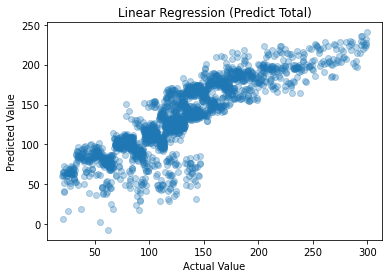

In [24]:
plt.scatter(y_test, y_pred, alpha=0.3)

plt.title('Linear Regression (Predict Total)')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')

plt.show()

## Interpreting a Models' Fit

### Residuals
The residual is defined as the difference between the _observed data point_ and the _predicted data point_ using a prediction equation. You can think of it as the _distance_ between your actual value vs your predicted value.

If the true data point is above the predicted value, the residual is positive. If the true data point is below, then the residual is negative. If the true data point is the same then the residual is zero. Ideally, this means we want residuals _close to 0_ which is the same as minimizing the errors made. 

### Residual Plots
A residual plot is a type of scatter plot where the x-axis represents the input variable(s) of the data, and the y-axis represents the residual values. 

If the points on the residual plot don't seem to have any pattern to them, then the model is a good fit for the data. A pattern to the residual plot can give you and idea of what might be wrong with your model. For example, it may show obvious outliers in the data, or that there is a pattern to the data so that the model does not really fit the data well.

### Interpreting Residual Plots
1. Do the points have large residuals (differences between true and estimated)?
    - _We want small residuals that are close to 0 (think minimizing the distance/errors)._
1. Is there a trend or bias in the residuals (i.e does the residuals look evenly spread and flat)?
    - _We don't want any bias or trend._
1. Is there a pattern or correlation in the residuals (i.e is there some kind of relationship in the residuals)?
    - _We don't want any correlation._
    
Lets draw the residual plot of the regression model we have built

In [25]:
# subtract the predicted values from the observed values
residuals = y_test - y_pred

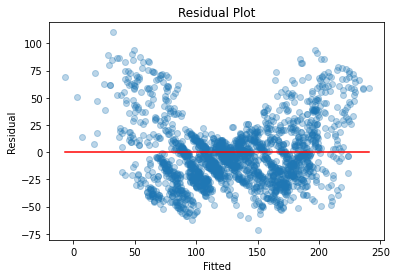

In [26]:
# plot residuals
plt.scatter(y_pred, residuals, alpha=0.3)

# plot the 0 line (we want our residuals close to 0)
plt.plot([min(y_pred), max(y_pred)], [0,0], color='red')

plt.title('Residual Plot')
plt.xlabel('Fitted')
plt.ylabel('Residual')

plt.show()

R2 0.9653056648214416
MSE 105.28372070636205


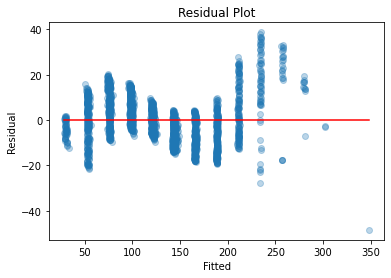

In [27]:
# create new X and y matrix
X_train = train[X_COLS + ['quantity']]
y_train = train[y_COL]
X_test = test[X_COLS + ['quantity']]
y_test = test[y_COL]

# fit lm2 
lm2 = LinearRegression()
lm.fit(X_train, y_train)

# evaluate model
y_pred = lm.predict(X_test)
r2 = lm.score(X_test, y_test)
mse = mean_squared_error(y_test, y_pred)

print('R2', r2)
print('MSE', mse)

# plot residuals
residuals = y_test - y_pred

plt.scatter(y_pred, residuals, alpha=0.3)
plt.plot([min(y_pred), max(y_pred)], [0,0], color='red')

plt.title('Residual Plot')
plt.xlabel('Fitted')
plt.ylabel('Residual')

plt.show()